Load modules.

In [1]:
import re

import matplotlib.pyplot as plt
import numpy as np
from triumvirate.winconv import Multipole, ThreePointWindow

from config import DATADIR

/Users/mikesw/Documents/Documents/Projects/Triumvirate/src/triumvirate/winconv.py:89: ExperimentalWarning: The `triumvirate.winconv` module is currently experimental. Its behaviour has not been fully tested and may change in the future.
  warnings.warn(


Set I/O.

In [2]:
CATALOGUE_BASE = "LRG_complete_SGC_0.4z0.6_mock0"
FILE_STEM = f"zetaw{{}}_full_{CATALOGUE_BASE}{{}}"
ALPHA_MONO = 1./(13.6801914399/3)

Declare scenarios.

In [3]:
MULTIPOLES = [Multipole('000'),]

DNUMSAMP_BASE = '_{}_dnumsamp_d3b3072'
DNUMSAMP_TAGS = ['3xF', '8xF', '13xF', '18xF']

REF_TAG = '_18xF_dnumsamp_d3b3072'

Load measuremnts.

In [4]:
contrasts = {
    DNUMSAMP_BASE.format(tag):
        ALPHA_MONO / int(re.findall(r'_(\d+)x', DNUMSAMP_BASE.format(tag))[0])
    for tag in DNUMSAMP_TAGS
}

window_files = {
    DNUMSAMP_BASE.format(tag): {
        multipole:
            DATADIR / "common" / "window-convergence-numsamp" /
            FILE_STEM.format(multipole.abstr, DNUMSAMP_BASE.format(tag))
        for multipole in MULTIPOLES
    }
    for tag in DNUMSAMP_TAGS
}
window_measurements = {
    filetag: ThreePointWindow.load_from_textfiles(
        window_files[filetag],
        alpha_contrast=contrasts[filetag],
        make_loglin=False
    )
    for filetag in window_files.keys()
}

/Users/mikesw/Documents/Documents/Projects/Triumvirate/src/triumvirate/winconv.py:943: UserWarning: Window function separation sample points are not logarithmically spaced.
  warnings.warn(


Visualise measurements.

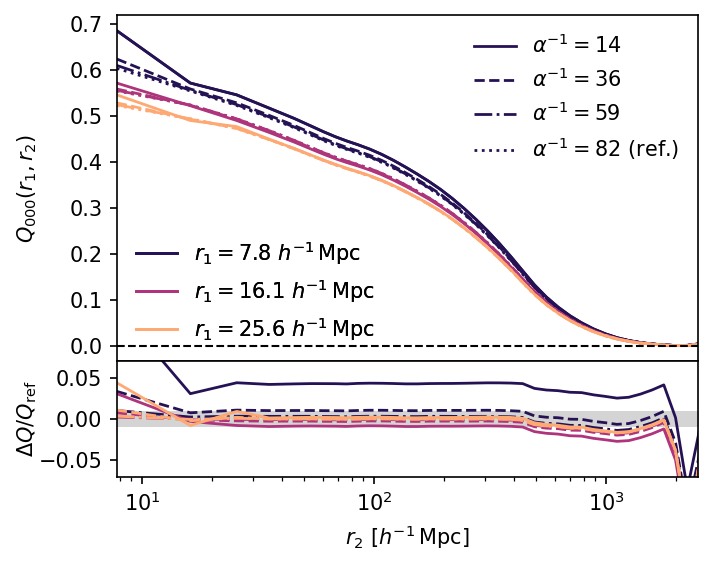

In [5]:
CMAP = plt.get_cmap('magma')
CMAP_OFFSET = 0.15

LW = 1.33
LINESTYLES = [
    '-',
    '--',
    '-.',
    ':',
]

NROW_MAIN = 3
NROW_DIFF = 1

RUNIT = r"$h^{-1}\,\mathrm{Mpc}$"
RPOW = 0

SLICE = slice(1, None)
RIND = [0, 1, 2,]

nrow = NROW_MAIN + NROW_DIFF
ncol = len(MULTIPOLES)

fig = plt.figure(
    figsize=(5.*ncol, 1.*nrow),
    dpi=150,
)

ccycle = []
for mpole_idx, multipole in enumerate(MULTIPOLES):
    ax_main_ = plt.subplot2grid(
        (nrow, ncol), (0, mpole_idx), rowspan=NROW_MAIN
    )
    ax_diff_ = plt.subplot2grid(
        (nrow, ncol), (NROW_MAIN, mpole_idx), rowspan=NROW_DIFF,
        sharex=ax_main_
    )

    c_init = not ccycle

    r_ref_ = window_measurements[REF_TAG].r[multipole][SLICE]

    for idxr, ridx in enumerate(RIND):
        r1_ = r_ref_[ridx]
        Qrow_ref_ = window_measurements[REF_TAG].Q[multipole][SLICE, SLICE][ridx]

        c_ = None if c_init else ccycle[idxr]

        for idxtag, (tag_, ls_) in enumerate(zip(DNUMSAMP_TAGS, LINESTYLES)):
            tag_ = DNUMSAMP_BASE.format(tag_)

            alpha_ = contrasts[tag_]

            r2_ = window_measurements[tag_].r[multipole][SLICE]
            Qrow_ = window_measurements[tag_].Q[multipole][SLICE, SLICE][ridx]

            label_ = []
            if (mpole_idx == 0) and (idxr == 0):
                label_a = fr"$\alpha^{{-1}} = {1/alpha_:.0f}$"
                if tag_ == REF_TAG: label_a += " (ref.)"
                label_.append(label_a)
            if (mpole_idx == len(MULTIPOLES) - 1) and (idxtag == 0):
                label_b = fr"$r_1 = {r1_:.1f}$ {RUNIT}"
                label_.append(label_b)
            if len(label_) == 0:
                label_ = None
            elif len(label_) == 1:
                label_ = label_.pop()

            if not isinstance(label_, list):
                if c_ is None:
                    line_ = ax_main_.semilogx(
                        r2_, r2_**RPOW * Qrow_,
                        c=CMAP(ridx / len(RIND) + CMAP_OFFSET),
                        ls=ls_, lw=LW, label=label_,
                    )
                    c_ = line_[0].get_color()
                else:
                    ax_main_.semilogx(
                        r2_, r2_**RPOW * Qrow_,
                        c=c_, ls=ls_, lw=LW, label=label_
                    )
            else:
                if c_ is None:
                    line_ = ax_main_.semilogx(
                        r2_, r2_**RPOW * Qrow_,
                        c=CMAP(ridx / len(RIND) + CMAP_OFFSET),
                        ls=ls_, lw=LW, label=label_[0],
                    )
                    line_ = ax_main_.semilogx(
                        r2_, r2_**RPOW * Qrow_,
                        c=CMAP(ridx / len(RIND) + CMAP_OFFSET),
                        ls=ls_, lw=LW, label=label_[1],
                    )
                    c_ = line_[0].get_color()
                else:
                    ax_main_.semilogx(
                        r2_, r2_**RPOW * Qrow_,
                        c=c_, ls=ls_, lw=LW, label=label_[0]
                    )
                    ax_main_.semilogx(
                        r2_, r2_**RPOW * Qrow_,
                        c=c_, ls=ls_, lw=LW, label=label_[1]
                    )

            if tag_ != REF_TAG:
                dQrow_ = Qrow_ / np.interp(r2_, r_ref_, Qrow_ref_) - 1.
                ax_diff_.semilogx(
                    r2_, dQrow_,
                    c=c_, ls=ls_, lw=LW
                )

    ax_main_.axhline(0., c='k', ls='--', lw=1.)

    ax_diff_.fill_between(
        r_ref_, -0.01, +0.01,
        facecolor='0.33', edgecolor='0.33', lw=0., alpha=.25
    )

    ax_main_.set_xlim(left=r_ref_.min(), right=1.75e3)
    ax_diff_.set_xlim(7.8, 2500.)
    ax_diff_.set_ylim(-0.07, 0.07)

    ax_main_.tick_params(labelbottom=False)
    if RPOW == 0:
        ax_main_.set_ylabel(fr"$Q_{{{multipole.abstr}}}(r_1, r_2)$")
    else:
        ax_main_.set_ylabel(fr"$r_2^{{{RPOW}}} Q_{{{multipole.abstr}}}(r_1, r_2)$")
    ax_diff_.set_ylabel(r"$\Delta Q / Q_\mathrm{ref}$")
    ax_diff_.set_xlabel(fr"$r_2$ [{RUNIT}]")

    ax_main_.yaxis.set_label_coords(-0.135, 0.5)
    ax_diff_.yaxis.set_label_coords(-0.135, 0.5)

    handles, labels = ax_main_.get_legend_handles_labels()

    handles_a = [handles[idx] for idx in [0, 2, 3, 4]]
    labels_a = [labels[idx] for idx in [0, 2, 3, 4]]

    handles_b = [handles[idx] for idx in [1, 5, 6]]
    labels_b = [labels[idx] for idx in [1, 5, 6]]

    legend_a = ax_main_.legend(
        handles_a, labels_a, loc='upper right', frameon=False
    )
    legend_b = ax_main_.legend(
        handles_b, labels_b, loc='lower left', frameon=False
    )

    ax_main_.add_artist(legend_a)
    ax_main_.add_artist(legend_b)

plt.subplots_adjust(hspace=0)